# Network State Index -- API demo

see: https://github.com/yzerlaut/Network_State_Index

We demonstrate the use of the API on the following publicly available dataset:

## the "Visual Coding – Neuropixels" dataset from the Allen Observatory

All details about this dataset and instructions for analysis are available at:

https://allensdk.readthedocs.io/en/latest/visual_coding_neuropixels.html

## Dataset download

I made a [custom script](https://github.com/yzerlaut/Network_State_Index/blob/main/demo/download_Allen_Visual-Coding_dataset.py) to download exclusively the part of the dataset of interest here (V1 probes).
You can run the script as:
```
python demo/download_Allen_Visual-Coding_dataset.py
```

In [1]:
# some general python / scientific-python modules
import os, shutil
import numpy as np
import pandas as pd
import matplotlib.pylab as plt

# the Network State Index API, see: https://github.com/yzerlaut/Network_State_Index
# install it with: "pip install git+https://github.com/yzerlaut/Network_State_Index"
import nsi

In [2]:
# Download and load the data with the "allensdk" API
# get the "allensdk" api with: "pip install allensdk"
from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache

# now let's define a cache repository for the data: by default ~/Downloads/ecephys_cache_dir
# insure that you have a "Downloads" repository in your home directory (/!\ non-english systems) or update below
data_directory = os.path.join(os.path.expanduser('~'), 'Downloads', 'ecephys_cache_dir')
manifest_path = os.path.join(data_directory, "manifest.json")
cache = EcephysProjectCache.from_warehouse(manifest=manifest_path)
all_sessions = cache.get_session_table() # get all sessions

### We restrict the analysis to:

    - wild type / wild type strain
    - male
    - recordings including V1 ("VISp")
    - "Brain Observatory 1.1" dataset

In [3]:
# let's filter the sessions according to the above criteria
sessions = all_sessions[(all_sessions.sex == 'M') & \
                        (all_sessions.full_genotype.str.find('wt/wt') > -1) & \
                        #(all_sessions.session_type == 'brain_observatory_1.1') & \
                        (all_sessions.session_type == 'functional_connectivity') & \
                        (['VISp' in acronyms for acronyms in all_sessions.ecephys_structure_acronyms])]
print(30*'--'+'\n--> Number of sessions with the desired characteristics: ' + str(len(sessions))+30*'--')
# sessions.head() # uncomment to see how they look

------------------------------------------------------------
--> Number of sessions with the desired characteristics: 11------------------------------------------------------------


## Minimal demo

In [ ]:
LFP = np.random.randn(100)
pLFP = NSI.compute_pLFP(LFP,
                       freqs=np.linspace(50, 300, 10))
NSI = NSI.compute_NSI(pLFP)

## In a more structured way

In [4]:
# let's do things in a bit more structured way
class Data:
    """
    an object to load, format and process the data
    """
    
    def __init__(self, session_index):
        """
        loading data according to the index of the "sessions" above
        """
        # we load a single session
        session = cache.get_session_data(sessions.index.values[session_index])

        # let's fetch the V1 probe --> always on "probeC"
        probe_id = session.probes[session.probes.description == 'probeC'].index.values[0]

        # let's fetch the lfp data for that probe and that session
        LFP_all_channels = session.get_lfp(probe_id)
        self.lfp_sampling_rate = session.probes.lfp_sampling_rate[probe_id]

        # let's fetch the channels corresponding to V1
        self.V1_channel_ids = session.channels[(session.channels.probe_id == probe_id) & \
                         (session.channels.ecephys_structure_acronym.isin(['VISp']))].index.values
        self.lfp_slice_V1 = LFP_all_channels.sel(channel=slice(np.min(self.V1_channel_ids), np.max(self.V1_channel_ids)))
        self.Nchannels_V1 = len(self.V1_channel_ids)
        self.t_LFP = self.lfp_slice_V1.time
        self.LFP = np.array(self.lfp_slice_V1)
        
        # using the LFP timestamps to get starting and duration times
        self.tstart, self.duration = float(self.t_LFP[0]), float(self.t_LFP[-1]-self.t_LFP[0])

        # let's fetch the isolated single units in V1
        V1_units = session.units[session.units.ecephys_structure_acronym == 'VISp'] # V1==VISp
        self.V1_RASTER = [session.spike_times[i] for i in V1_units.index] # RASTER = a list over units of spiketimes
        
        # let's fetch the running speed
        self.t_running_speed = .5*(session.running_speed.start_time.values+session.running_speed.end_time.values)
        self.running_speed = session.running_speed.velocity

        # let's compute the population activity from the spikes
        self.compute_pop_act() # you can recall this functions with different bins/smoothing        
        
    def compute_pop_act(self, 
                        pop_act_bin=5e-3,
                        pop_act_smoothing=20e-3):
        """
        we bin spikes to compute population activity
        """
        t_pop_act = self.tstart+np.arange(int(self.duration/pop_act_bin)+1)*pop_act_bin
        pop_act = np.zeros(len(t_pop_act)-1)

        for i, spikes in enumerate(self.V1_RASTER):
            pop_act += np.histogram(spikes, bins=t_pop_act)[0]
        pop_act /= (len(self.V1_RASTER)*pop_act_bin)

        self.t_pop_act = .5*(t_pop_act[1:]+t_pop_act[:-1])
        self.pop_act = NSI.gaussian_filter1d(pop_act, int(pop_act_smoothing/pop_act_bin)) # filter from scipy
        
    def compute_pLFP(self, 
                     channelID=None,
                     t0=0, 
                     duration=20):
        """
        ------------------------------
            HERE we use the NSI API
        ------------------------------
        by default on a zoom of the data, not the entire trace as this can be long
        call: "data.compute_pLFP(duration=data.duration)" to have it on the full trace
        
        pLFP in microvolts (uV)
        """
        lfp_slice = self.lfp_slice_V1.sel(time=slice(t0,t0+duration))
        
        if channelID is not None:
            self.t_pLFP, self.pLFP = NSI.compute_pLFP(1e6*np.array(lfp_slice)[:,channelID],
                                                      self.lfp_sampling_rate)
        else:
            # sum over all channels
            self.t_pLFP, self.pLFP = NSI.compute_pLFP(1e6*np.array(lfp_slice).T,
                                                      self.lfp_sampling_rate)
        self.t_pLFP += t0

    def plot(self, quantity, t0=0, duration=np.inf,
             ax=None,
             color='k', lw=1):
        """
        quantity as a string (e.g. "pLFP" or "running_speed")
        """
        if hasattr(self, quantity):
            if ax is None:
                fig, ax =plt.subplots(1, figsize=(8,3))
            else:
                fig = None
            cond = (getattr(self, 't_'+quantity)>t0) & (getattr(self, 't_'+quantity)<(t0+duration))
            ax.plot(getattr(self, 't_'+quantity)[cond], getattr(self, quantity)[cond], color=color, lw=lw)
            return fig, ax
        else:
            print('%s not an attribute of data' % quantity)

    
data = Data(0)

(<Figure size 576x216 with 1 Axes>, <AxesSubplot:>)

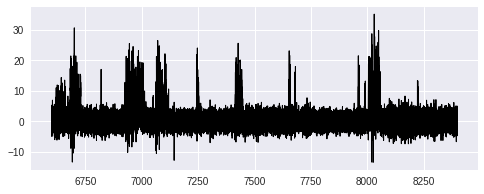

In [28]:
data.plot('running_speed', t0=110*60, duration=30*60)

(<Figure size 576x216 with 1 Axes>, <AxesSubplot:>)

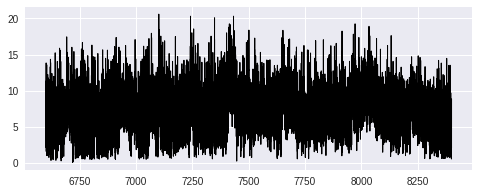

In [27]:
data.plot('pop_act', t0=110*60, duration=30*60)

(<Figure size 576x216 with 1 Axes>, <AxesSubplot:>)

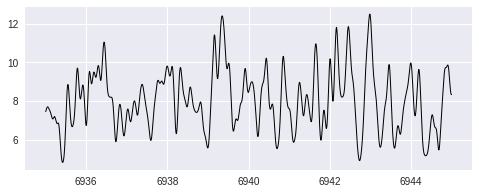

In [26]:
data.plot('pop_act', t0=6935, duration=10)

(<Figure size 576x216 with 1 Axes>, <AxesSubplot:>)

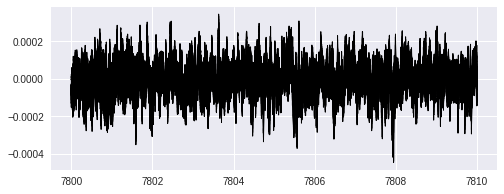

In [37]:
data.plot('LFP', t0=7800, duration=10)

In [6]:
np.array(data.lfp_slice_V1).shape

(12254090, 22)

In [14]:
plt.style.use('seaborn')

def plot_sample_data(data,
                     time_points=[100, 1000],
                     duration=2., 
                     pop_act_bin=5e-3):

    fig, AX_full = plt.subplots(5,len(time_points), figsize=(3*len(time_points), 6))
    if len(time_points)==1:
        AX_full = [AX_full]
        
    YLIMS = [[np.inf, -np.inf] for i in range(len(AX_full))]
    for t0, AX in zip(time_points, AX_full.T):
        
        # raster plot
        for i, spikes in enumerate(data.V1_RASTER):
            cond = (spikes>t0) & (spikes<(t0+duration))
            AX[0].plot(spikes[cond], i+0*spikes[cond], 'ko', ms=1.5)

        # pop act. plot
        data.plot('pop_act', t0=t0, duration=duration, ax=AX[1])
        
        # LFP plot
        lfp_slice = data.lfp_slice_V1.sel(time=slice(t0,t0+duration))
        for i in range(len(lfp_slice.channel.values)):
            AX[2].plot(lfp_slice.time, 1e3*lfp_slice.sel(channel=lfp_slice.channel[i]), 
                       lw=0.2, color=plt.cm.copper(1-i/(len(lfp_slice.channel.values)-1)))
        
        # speed plot
        data.plot('running_speed', t0=t0, duration=duration, ax=AX[4])

        # pLFP plot
        data.compute_pLFP(t0=t0-2, duration=duration+4, channelID=1)
        data.plot('pLFP', t0=t0, duration=duration, ax=AX[3])
        
        # labelling axes and setting the same limes
        for j, label, ax in zip(range(len(AX)), 
                                ['units', 'rate (Hz)', 'LFP (mV)', 'pLFP (uV)', 'run. speed\n(cm/s)'], AX):
            if ax in AX_full.T[0]:
                ax.set_ylabel(label)
            ax.set_xticks([])
            ax.set_xlim([t0,t0+duration])
            YLIMS[j] = [np.min([AX[j].get_ylim()[0], YLIMS[j][0]]),
                        np.max([AX[j].get_ylim()[1], YLIMS[j][1]])]
        AX[0].set_title('$t_0$=%.1fs' % (t0), size='small')
        
    for AX in AX_full.T:
        for j in range(len(AX)):
            try:
                AX[j].set_ylim(YLIMS[j])
            except BaseException:
                pass
    for t0, AX in zip(time_points, AX_full.T):
        AX[0].plot([t0,t0+0.2], YLIMS[0][1]*np.ones(2), 'k-', lw=1)
        AX[0].annotate('200ms', (t0, AX[0].get_ylim()[1]))
                        


In [ ]:
plot_sample_data(data, time_points=[7199.5, 7531, 7421.5]) # session 1

In [29]:
t0, duration = 200, 10
data.compute_pLFP(t0=t0-2, duration=duration+4, channelID=19)
data.t_pLFP

array([198.   , 198.005, 198.01 , ..., 212.565, 212.57 , 212.575])

In [ ]:
data.compute_pLFP(t0=t0-2, duration=duration+4, channelID=19)
